In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading in hand charted match data
match_info=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/CHARTING M MATCHES WORK.xlsx')
return_outcomes=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-ReturnOutcomes WORK.xlsx')
net_points=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-NetPoints WORK.xlsx')
overview=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-Overview WORK.xlsx')
rally_=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-Rally WORK.xlsx')
serve_influence=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-ServeInfluence WORK.xlsx')
shot_direction=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-ShotDirection WORK.xlsx')
shot_types=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-ShotTypes WORK.xlsx')
serve_volley=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-SnV WORK.xlsx')

In [ ]:
#Cleaning
dfs=[match_info,return_outcomes,net_points,overview,rally_,serve_influence,shot_direction,shot_types,serve_volley]
for i,df in enumerate(dfs):
  dfs[i]=dfs[i].dropna()

In [ ]:
#Removing set based statistics and keeping only total statistics for each match
return_outcomes.head()
return_outcomes_1=return_outcomes.loc[return_outcomes['row']=='Total']
return_outcomes_1=return_outcomes_1.drop(columns=['row'])

#net_points is already totaled

overview_1=overview.loc[overview['set']=='Total']
overview_1=overview_1.drop(columns=['set'])

rally_1=rally_.loc[rally_['row']=='Total']
rally_1=rally_1.drop(columns=['row'])

#serve influence

shot_direction_1=shot_direction.loc[shot_direction['row']=='Total']
shot_direction_1=shot_direction_1.drop(columns='row')

shot_types_1=shot_types.loc[shot_types['row']=='Total']
shot_types_1=shot_types_1.drop(columns=['row'])

serve_volley_1=serve_volley.loc[serve_volley['row'].isin(['SnV','nonSnV'])]

In [ ]:
#Messing with shots column to get rid of some unnecessary statistics (these metrics are already explained in other columns or are not relevant to anything 
#I'm currently interested in)
shot_types_1=shot_types_1.drop(columns=['winners','serve_return','unforced','shots_in_pts_lost'])

In [ ]:
#Joining on multiple columns to get one dataframe with two rows for each match where each row contains player 1 or player 2 stats
joined=match_info.merge(overview_1,on='match_id')
joined_1=joined.merge(shot_direction_1,on=['match_id','player'])
joined_2=joined_1.merge(shot_types_1,on=['match_id','player'])

In [ ]:
#Creating different dataframes to make joining on keys more match_id and player a little easier
rally_1_p1=rally_1[['match_id','pts','pl1_won']]
rally_1_p2=rally_1[['match_id','pts','pl2_won']]

rally_1_p1['player']=np.zeros(rally_1_p1.shape[0],dtype=int)+1
rally_1_p2['player']=np.ones(rally_1_p2.shape[0],dtype=int)+1

rally_1_p1=rally_1_p1.rename(columns={'pl1_won':'pts_won'})
rally_1_p2=rally_1_p2.rename(columns={'pl2_won':'pts_won'})

rally_2=pd.concat([rally_1_p1,rally_1_p2])

In [ ]:
#Joining master dataset with newly created dataset
joined_3=joined_2.merge(rally_2,on=['match_id','player'])

In [ ]:
#Changing a column name to avoid ambiguity
joined_3=joined_3.rename(columns={'shots':'total_shots'})

In [ ]:
#Cleaning serve and volley dataset
snv_finalized=serve_volley_1.loc[serve_volley_1['row']=='SnV']
snv_finalized=snv_finalized.drop(columns=['row','aces','unret','return_forced','net_winner','induced_forced','net_unforced','passed_at_net','passing_shot_induced_forced','total_shots'])
snv_finalized=snv_finalized.rename(columns={'pts_won':'snv_pts_won'})

In [ ]:
#Cleaning net points dataset
net_points_1=net_points.loc[net_points['row']=='NetPoints']
net_points_1=net_points_1.drop(columns=['row','net_winner','induced_forced','net_unforced','passed_at_net','passing_shot_induced_forced','total_shots'])
net_points_1=net_points_1.rename(columns={'pts_won':'net_pts_won'})

In [ ]:
#Joining net_points to existing master df
joined_4=joined_3.merge(net_points_1,on=['match_id','player'])

In [ ]:
#Joining 
joined_5=joined_4.merge(snv_finalized,on=['match_id','player'])

In [ ]:
#Here, we can see that we lose almost 2000 matches when joinining the two dataframes. This is because many matches are missing the serve and volley
#percentage column. We will work on imputing this data later in the notebook
print(joined_4.shape)
print(joined_5.shape)

(4804, 47)
(3076, 49)


In [ ]:
#Removing more unnecessary columns
joined_5=joined_5.drop(columns=joined_5.columns[3:13])
joined_5=joined_5.drop(columns=['Final TB?','Charted by','Best of'])

joined_4=joined_4.drop(columns=joined_4.columns[3:13])
joined_4=joined_4.drop(columns=['Final TB?','Charted by','Best of'])

In [ ]:
#Getting rid of the irrelevant player in each row and making a new "Player Name" row in the dataframe
joined_5['Player_Name']=joined_5.apply(lambda row: row['Player 1'] if row['player']==1 else row['Player 2'],axis=1)
joined_4['Player_Name']=joined_4.apply(lambda row: row['Player 1'] if row['player']==1 else row['Player 2'],axis=1)

In [ ]:
#Moving Player_Name to front
cols=joined_5.columns.tolist()
cols.insert(1,cols[-1])
cols.pop(-1)
joined_5=joined_5[cols]

cols1=joined_4.columns.tolist()
cols1.insert(1,cols1[-1])
cols1.pop(-1)
joined_4=joined_4[cols1]

In [ ]:
#Dropping Player 1 and Player 2 columns from joined_5 (leaving player # column in case I want to add more data later)
joined_5=joined_5.drop(columns=['Player 1','Player 2'])
joined_4=joined_4.drop(columns=['Player 1','Player 2'])

In [ ]:
#Creating useful columns for analysis (mostly percentages)
joined_5['first_serve_percen']=joined_5['first_in']/joined_5['serve_pts']
joined_5['pt_ending_shot_percen']=joined_5['pt_ending']/joined_5['total_shots']
joined_5['av_shots_per_pt_won']=joined_5['shots_in_pts_won']/joined_5['pts_won']
joined_5['first_serve_pts_won_percen']=joined_5['first_won']/joined_5['first_in']
joined_5['second_serve_pts_won_percen']=joined_5['second_won']/joined_5['second_in']
joined_5['net_points_percen']=joined_5['net_pts']/joined_5['pts']
joined_5['net_points_won_percen']=joined_5['net_pts_won']/joined_5['net_pts']
joined_5['snv_percen']=joined_5['snv_pts']/joined_5['serve_pts']
joined_5['ace_percen']=joined_5['aces']/joined_5['serve_pts']
joined_5['snv_pts_won_percen']=joined_5['snv_pts_won']/joined_5['snv_pts']
joined_5['return_pts_won_percen']=joined_5['return_pts_won']/joined_5['return_pts']
joined_5['percen_unsafe_shots_made']=joined_5[['down_the_line','inside_out','inside_in']].sum(axis=1)/joined_5[['down_the_line','inside_out','inside_in','crosscourt','down_middle']].sum(axis=1)
joined_5['break_pts_percen']=joined_5['bk_pts']/joined_5['serve_pts']
joined_5['percen_pts_lost_from_unforced']=joined_5['unforced']/(joined_5['pts']-joined_5['pts_won'])
joined_5['percen_pts_won_from_winner_FE']=(joined_5['winners']+joined_5['induced_forced'])/joined_5['pts_won']


joined_4['first_serve_percen']=joined_4['first_in']/joined_4['serve_pts']
joined_4['pt_ending_shot_percen']=joined_4['pt_ending']/joined_4['total_shots']
joined_4['av_shots_per_pt_won']=joined_4['shots_in_pts_won']/joined_4['pts_won']
joined_4['first_serve_pts_won_percen']=joined_4['first_won']/joined_4['first_in']
joined_4['second_serve_pts_won_percen']=joined_4['second_won']/joined_4['second_in']
joined_4['net_points_percen']=joined_4['net_pts']/joined_4['pts']
joined_4['net_points_won_percen']=joined_4['net_pts_won']/joined_4['net_pts']
joined_4['ace_percen']=joined_4['aces']/joined_4['serve_pts']
joined_4['return_pts_won_percen']=joined_4['return_pts_won']/joined_4['return_pts']
joined_4['percen_unsafe_shots_made']=joined_4[['down_the_line','inside_out','inside_in']].sum(axis=1)/joined_4[['down_the_line','inside_out','inside_in','crosscourt','down_middle']].sum(axis=1)
joined_4['break_pts_percen']=joined_4['bk_pts']/joined_4['serve_pts']
joined_4['percen_pts_lost_from_unforced']=joined_4['unforced']/(joined_4['pts']-joined_4['pts_won'])
joined_4['percen_pts_won_from_winner_FE']=(joined_4['winners']+joined_4['induced_forced'])/joined_4['pts_won']

In [ ]:
#Creating a new dataset contianing mostly only useful columns
cluster_set_1=joined_5.drop(columns=joined_5.columns[3:34])
cluster_set_1=cluster_set_1.drop(columns=['snv_pts_won'])
cluster_set_1=cluster_set_1.drop(columns=['snv_pts_won_percen'])

missing_snv=joined_4.drop(columns=joined_4.columns[3:33])

In [ ]:
#Grouping relevant columns by player and finding the mean for each player
cluster_set_1_grouped=cluster_set_1.groupby('Player_Name').mean().reset_index()
cluster_set_1_grouped=cluster_set_1_grouped.drop(columns=['player'])

#Doing the same for the dataset containing players that are not in the original dataset and missing serve and volley
#percentage
missing_snv=missing_snv.loc[~missing_snv['Player_Name'].isin(cluster_set_1_grouped['Player_Name'].unique())]
missing_snv_grouped=missing_snv.groupby('Player_Name').mean().reset_index()
missing_snv_grouped=missing_snv_grouped.drop(columns=['player'])

In [ ]:
#Comparing two very differnet stylistic players to make sure the data makes sense
cluster_set_1_grouped.loc[cluster_set_1_grouped['Player_Name'].isin(['David Ferrer','John Isner'])]

Player_Name  first_serve_percen  pt_ending_shot_percen  \
84   David Ferrer            0.662788               0.115511   
194    John Isner            0.695712               0.309722   

     av_shots_per_pt_won  first_serve_pts_won_percen  \
84              2.351317                    0.599008   
194             0.929733                    0.761807   

     second_serve_pts_won_percen  net_points_percen  net_points_won_percen  \
84                      0.459102           0.124233               0.653495   
194                     0.532544           0.163428               0.653709   

     snv_percen  ace_percen  return_pts_won_percen  percen_unsafe_shots_made  \
84     0.013899    0.001795               0.297954                  0.317681   
194    0.134558    0.190781               0.262911                  0.407395   

     break_pts_percen  percen_pts_lost_from_unforced  \
84           0.106321                       0.271738   
194          0.061391                       0.348543   

     percen_pts_won_from_winner_FE  
84                        0.267915  
194                       0.561044

In [ ]:
#Checking the correlation matrix to see which columns may be correlated
cluster_set_1_grouped.corr()

#Here, we can see that pt_ending_shot_percen, net_points_percen, and av_shots_per_pt_won are all correlated with snv_percen, where pt_ending_shot_percen 
#is very positively correlated with snv_percen.

#Since this data is roughly incomplete (many potential rows are missing serve and volley statistics) we are interested in predicting snv_percen based based 
#on some of the other features in this dataset. This not only helps us get more data, but also provides insight into the number of times we can expect a 
#player to serve and volley based on statistics we already have. This can be of use to players preparing before matches that may not have access to 
#detailed data

first_serve_percen  pt_ending_shot_percen  \
first_serve_percen                       1.000000              -0.071620   
pt_ending_shot_percen                   -0.071620               1.000000   
av_shots_per_pt_won                      0.022561              -0.678369   
first_serve_pts_won_percen              -0.038694               0.308221   
second_serve_pts_won_percen              0.007826               0.101058   
net_points_percen                       -0.063378               0.449785   
net_points_won_percen                    0.117311               0.036281   
snv_percen                              -0.043694               0.533151   
ace_percen                              -0.035194               0.360387   
return_pts_won_percen                    0.065614              -0.193170   
percen_unsafe_shots_made                 0.008678               0.348103   
break_pts_percen                        -0.123857              -0.227029   
percen_pts_lost_from_unforced           -0.094702              -0.057768   
percen_pts_won_from_winner_FE           -0.046586               0.513827   

                               av_shots_per_pt_won  \
first_serve_percen                        0.022561   
pt_ending_shot_percen                    -0.678369   
av_shots_per_pt_won                       1.000000   
first_serve_pts_won_percen               -0.359448   
second_serve_pts_won_percen              -0.064533   
net_points_percen                        -0.257866   
net_points_won_percen                     0.002977   
snv_percen                               -0.416041   
ace_percen                               -0.470788   
return_pts_won_percen                     0.382363   
percen_unsafe_shots_made                 -0.212628   
break_pts_percen                          0.244229   
percen_pts_lost_from_unforced             0.375580   
percen_pts_won_from_winner_FE            -0.137140   

                               first_serve_pts_won_percen  \
first_serve_percen                              -0.038694   
pt_ending_shot_percen                            0.308221   
av_shots_per_pt_won                             -0.359448   
first_serve_pts_won_percen                       1.000000   
second_serve_pts_won_percen                      0.385429   
net_points_percen                                0.074874   
net_points_won_percen                            0.449480   
snv_percen                                       0.123565   
ace_percen                                       0.562538   
return_pts_won_percen                            0.155843   
percen_unsafe_shots_made                         0.130559   
break_pts_percen                                -0.731248   
percen_pts_lost_from_unforced                   -0.170251   
percen_pts_won_from_winner_FE                    0.226105   

                               second_serve_pts_won_percen  net_points_percen  \
first_serve_percen                                0.007826          -0.063378   
pt_ending_shot_percen                             0.101058           0.449785   
av_shots_per_pt_won                              -0.064533          -0.257866   
first_serve_pts_won_percen                        0.385429           0.074874   
second_serve_pts_won_percen                       1.000000          -0.026951   
net_points_percen                                -0.026951           1.000000   
net_points_won_percen                             0.287861          -0.165048   
snv_percen                                       -0.015398           0.908304   
ace_percen                                        0.193725           0.128968   
return_pts_won_percen                             0.345029          -0.093570   
percen_unsafe_shots_made                          0.032912           0.072260   
break_pts_percen                                 -0.589494          -0.020047   
percen_pts_lost_from_unforced                    -0.126685          -0.309884   
percen_pts_won_from_winner_FE

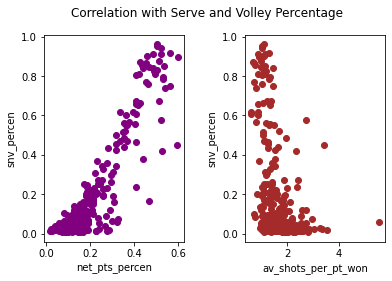

In [ ]:
#Here, we examine a plot of snv_percen vs. net_points_percen
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
fig.tight_layout(pad=3)
axs[0].scatter(cluster_set_1_grouped['net_points_percen'],cluster_set_1_grouped['snv_percen'],color='purple')
axs[1].scatter(cluster_set_1_grouped['av_shots_per_pt_won'],cluster_set_1_grouped['snv_percen'],color='brown')
fig.suptitle('Correlation with Serve and Volley Percentage')
axs[0].set_ylabel('snv_percen')
axs[0].set_xlabel('net_pts_percen')
axs[1].set_ylabel('snv_percen')
axs[1].set_xlabel('av_shots_per_pt_won')
plt.show()

In [ ]:
#Since some of the data is missing, we will use a couple techniques to attempt to impute serve and volley percentage for the missing samples. The first
#technique we will use is linear regression using LASSO for feature selection
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [ ]:
#Creating matrices from dataframes 
X=cluster_set_1_grouped.loc[:,~cluster_set_1_grouped.columns.isin(['Player_Name','snv_percen'])].to_numpy()
Y=cluster_set_1_grouped['snv_percen'].to_numpy()#.reshape((len(cluster_set_1_grouped['snv_percen']),1))

In [ ]:
from sklearn.model_selection import train_test_split
#Creating train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [ ]:
from scipy.special import logit
#Since the dependent variable in this case is a percentage, we use the logit function to map the probabilities to the real line to hopefully avoid
#negative numbers as predictions
Y_train_logit=logit(Y_train)
Y_test_logit=logit(Y_test)

In [ ]:
#Creating a large range of alphas to find the general region where the best alpha lies
alphas=np.arange(.0001,100000,5)

In [ ]:
#Using cross validation to select the best tuning paramater for the additional constraint on the coefficients of the model
lasreg_cv=LassoCV(alphas=alphas)
lasreg_cv.fit(X_train,Y_train_logit)

#Optimal alpha
print(lasreg_cv.alpha_)

0.0001


In [ ]:
#Seems like the optimal alpha is pretty small, so we rerun with a smaller range of values
alphas=np.arange(.00001,.001,.000001)
lasreg_cv=LassoCV(alphas=alphas)
lasreg_cv.fit(X_train,Y_train_logit)

#Optimal alpha
print(lasreg_cv.alpha_)

0.0005350000000000003


In [ ]:
#Creating new model with best alpha
lasreg=Lasso(alpha=lasreg_cv.alpha_)
lasreg.fit(X_train,Y_train_logit)
preds=lasreg.predict(X_test)
score=lasreg.score(X_test,Y_test_logit)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.special import expit
#Here, we can see that the R^2 is very close to one, so we are confident our model generalizes well to the testing data
print(f'The R^2 is {score}')

#MSE for training set
y_pred_train=lasreg.predict(X_train)
print(f'The train MSE is {mean_squared_error(Y_train_logit,y_pred_train)}')

#MSE for testing set
y_pred_test=lasreg.predict(X_test)
print(f'The test MSE is {mean_squared_error(Y_test_logit,y_pred_test)}')

#MAE for training set after transforming train targets from real #s back to percentages using a sigmoid function
y_pred_train_percen=expit(y_pred_train)
print(f'The transformed train MAE is {mean_absolute_error(Y_train,y_pred_train_percen)}')

#MAE for test set after transforming test targets from real #s back to percentages using a sigmoid function
y_pred_test_percen=expit(y_pred_test)
print(f'The transformed test MAE is {mean_absolute_error(Y_test,y_pred_test_percen)}')

The R^2 is 0.8499992853074041
The train MSE is 0.4040153969332314
The test MSE is 0.5125857417907108
The transformed train MAE is 0.03744111684621732
The transformed test MAE is 0.036356431554451916


In [ ]:
#Next, we use the model above to generate predictions for the rows that have missing data. This part requires the missing_snv_grouped dataset created above
missing_snv_grouped=missing_snv_grouped.dropna()
missing_snv_X=missing_snv_grouped.iloc[:,1:].to_numpy()
snv_preds=lasreg.predict(missing_snv_X)

#Changing model predictions from real numbers to percentages
snv_preds=expit(snv_preds)

In [ ]:
#Adding snv_percen to dataframe missing the column
missing_snv_grouped['snv_percen']=snv_preds

In [ ]:
#Checking shapes before concatenating
print(missing_snv_grouped.shape)
print(cluster_set_1_grouped.shape)

#Concatenating dataset with imputed values to dataset without missing values
full_set=pd.concat([cluster_set_1_grouped,missing_snv_grouped]).reset_index()

(138, 15)
(411, 15)


In [ ]:
#Reading in labels for dataset to be used in supervised learning
classes=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Groupings/groups_final_finished.xlsx')

In [ ]:
#Getting rid of bad labels
classes=classes[classes['class_rd']!=0]
classes['class_rd']=classes['class_rd'].astype(float).round(0)

In [ ]:
#Creating dataset of classes and 
data_classes=full_set.merge(classes[['Player_Name','class_rd']],on='Player_Name')
data_classes=data_classes.drop(columns=['index'])

In [ ]:
#Exporting new CSV
data_classes.to_csv('/content/drive/MyDrive/MATH 642 Final Project/Data/full_dataset_labeled.csv')

In [ ]:
#Creating a different CSV with player physical data (height weight)
phys_chars=pd.read_csv('/content/drive/MyDrive/MATH 642 Final Project/Data/Non-charting data/physical_chars.csv')

In [ ]:
#Joining with current dataset on Player_Name column
phys_chars_classes=data_classes.merge(phys_chars,on='Player_Name')
phys_chars_classes=phys_chars_classes.dropna()

#Removing indices from join
phys_chars_classes=phys_chars_classes.drop(columns=['Unnamed: 0'])

#Deleting columns we don't want
phys_chars_classes=phys_chars_classes.loc[:,phys_chars_classes.columns.isin(['Player_Name','height_inches','weight_lbs','birth_year','class_rd'])]

In [ ]:
phys_chars_classes.to_csv('/content/drive/MyDrive/MATH 642 Final Project/Data/physical_chars_dataset.csv')